### KG using relationformer

The code here uses [relationformer](https://github.com/suprosanna/relationformer?tab=readme-ov-file) framework for scene graph generation
The broad view of this architecture is in the figure below taken from the [original paper](https://arxiv.org/pdf/2203.10202).You can also use [this code](https://github.com/anant37289/relationformer) where i've made some code changes to adapt it to higher pytorch versions.
- Images are first coverted to patch token using an image encoder.
- Then an encoder decoder architecture is used to make [obj] token (which is used for object detection), and the [rel] token(which is used for relation prediction between the objects). There is an assumption here that the number of objects in the image is less than the number of object tokens.


<nop/> <div style="width: 500px;">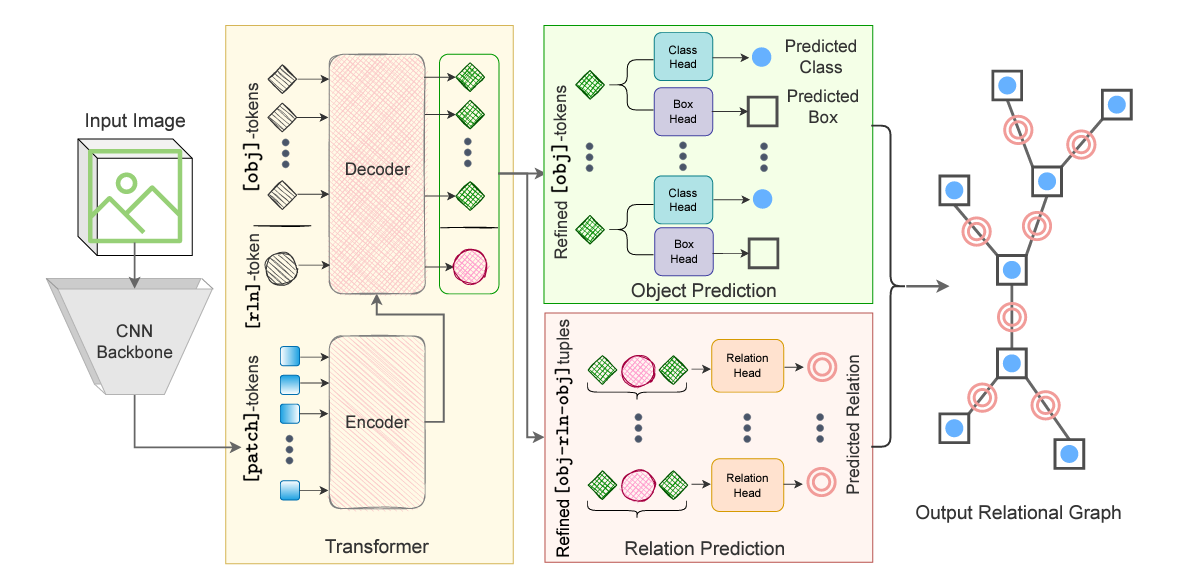</div>


- The code here is for inference 
- For detailed setup refer to the original repository, SGG branch.
- For checkpoints see [this](https://drive.google.com/file/d/1Q1Nfvi2Frro6aVqRR8M_mD4OuZ6yhNRv/view?usp=sharing).
    - I only trained this for 5 epochs and i also change the model dimension to fit my 12GB gpus. 
    - I have added my custom configs and the cuda 11.2 conda environent for trainig which you can find in the accompanying assets. The python version is 3.9.19.
- If you wish to train here is the completely [compiled dataset](https://drive.google.com/drive/folders/1-77DLCL__TBx7PxvMK73Q6s49fcu5XXw?usp=sharing). Ater downloading unzip the images into VG_100K folder.



#### import dependencies
to run this notebook place it in the base directory of the rf code

In [1]:
import yaml
import json
import h5py
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import text, patheffects

import torch
import torchvision.transforms as T

from datasets.sparse_targets import FrequencyBias
from PIL import Image

import networkx as nx

from models import build_model
from inference import graph_infer
import box_ops_2D as box_ops

#### load configs

In [2]:
class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)


with open('/home/anantjain/anant/relationformer/configs/scene_2d.yaml',"r") as f:#custom configs 
    config = yaml.load(f, Loader=yaml.FullLoader)

config = dict2obj(config)
config.MODEL.RESUME = ''
config.log.exp_name = 1
config.DATA.BATCH_SIZE = 2

#### load dataset

In [ ]:
roi = h5py.File('./data/visual_genome/stanford_filtered/VG-SGG.h5','r')

#### looking at the final dataset structure and organisation
- Here i've just looked at the dataset structure, mainly the fields of VG_SGG.h5. The cells here are not requered for the rest of the inference code

the dataset is organized as
```
code_root/
└── data/
    └── visual_genome/
        ├── VG.pt
        ├── obj_count.pkl
        ├── VG_100K/
        |    ├── 1.jpg
        |    ├── 2.jpg
        |    ├── ...
        |    └── ...
        └── stanford_filtered/
             ├── image_data.json
             ├── proposals.h5
             ├── VG-SGG-dicts.json
             └── VG-SGG.h5

```
- for description of stanford_filtered refer: https://github.com/danfeiX/scene-graph-TF-release/blob/master/data_tools/README.md, here proposals.h5 is not used

here is a detailed description of all the VG_SGG.h5 which gives the main annotaion of bounding boxes and relations
- there are 150 object classes and 50 relations in the dataset

the roi(region of interest) data looks like this

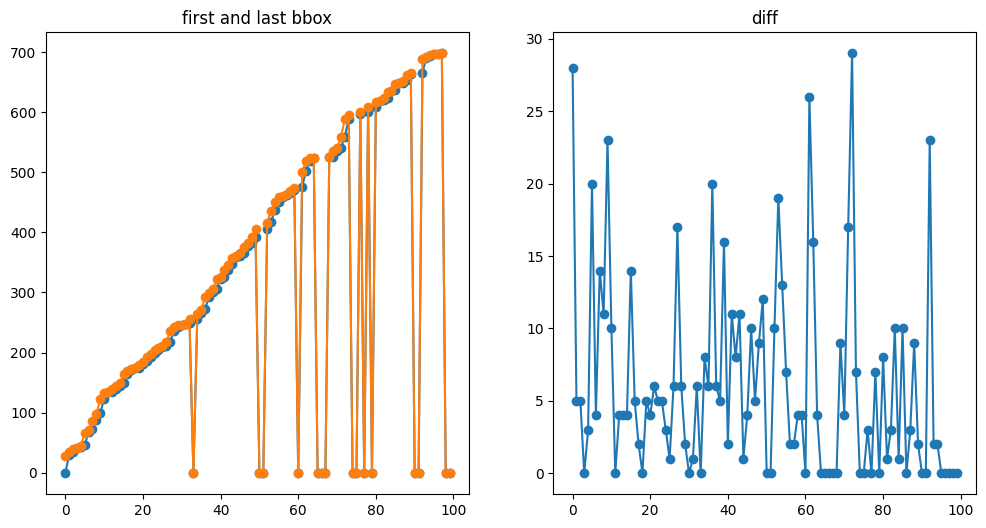

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(roi['img_to_first_rel'][:100],marker='o',linestyle='-')
ax1.plot(roi['img_to_last_rel'][:100],marker='o',linestyle='-')
ax1.title.set_text('first and last bbox')
ax2.plot(roi['img_to_last_rel'][:100]-roi['img_to_first_rel'][:100],marker='o',linestyle='-')
ax2.title.set_text('diff')
plt.show()

annotation for which to which bounding boxes for this image\
0 for none

In [5]:
max(roi['img_to_last_rel'][:]),max(roi['labels'][:,0])#150 classes and 622704 bbox

(622704, 150)

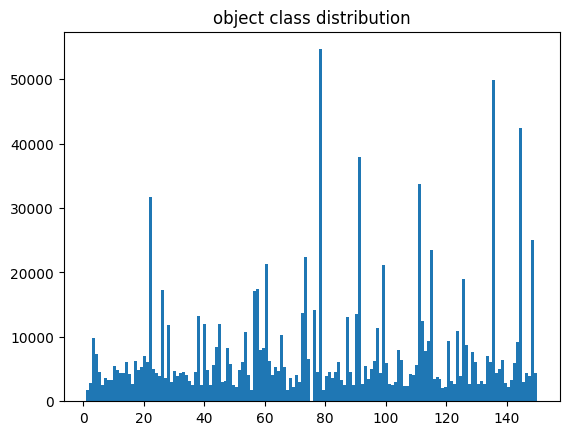

In [6]:
plt.hist(roi['labels'][:,0],bins=151)
plt.title('object class distribution')
plt.show()

In [7]:
all_boxes = roi['boxes_{}'.format(1024)][:]## boxes present in scales 1024(in 1024 scaled coordinates)
_relations = roi['relationships'][:]## this gives the index of the objects in the bbox(b/w which the relation is present)
_relation_predicates = roi['predicates'][:, 0]## this gives the relation between the objects

```python
#convert from xc, yc, w, h to x1, y1, x2, y2
all_boxes[:, :2] = all_boxes[:, :2] - all_boxes[:, 2:] / 2
all_boxes[:, 2:] = all_boxes[:, :2] + all_boxes[:, 2:]
```

#### run inference

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(config)
model = model.to(device)
config.MODEL.DECODER.FREQ_BIAS=False    #TODO: check this for using frequency baseline
if config.MODEL.DECODER.FREQ_BIAS: # use freq bias
    freq_baseline = FrequencyBias(config.DATA.FREQ_BIAS, train_ds)
net_wo_dist = model
relation_embed = model.relation_embed
freq_baseline = freq_baseline.to(device) if config.MODEL.DECODER.FREQ_BIAS else None

In [109]:
### load model
ckpt_path = './trained_weights/runs/1_10/models/checkpoint_epoch=5.pt'
checkpoint = torch.load(ckpt_path, map_location=device)

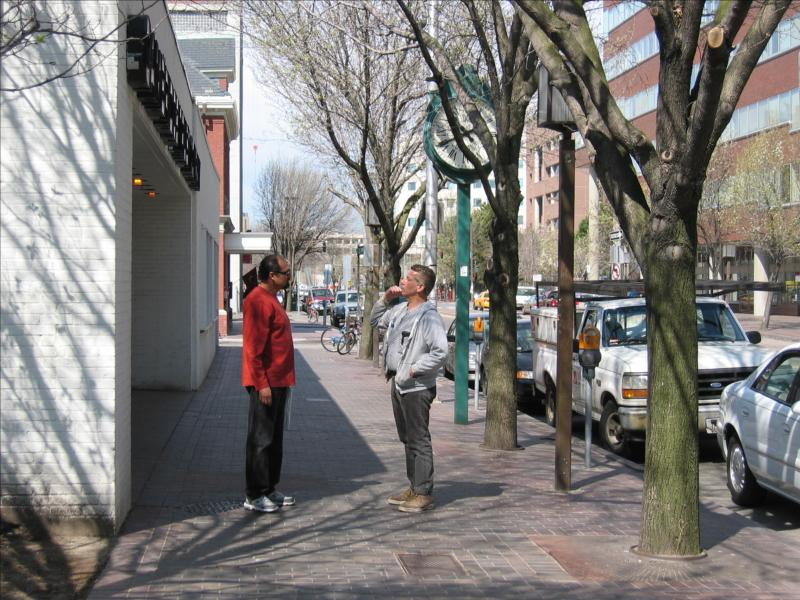

In [110]:
### load inference image
image = Image.open('1.jpg').convert('RGB')
image

In [111]:
### the resize is taken from val loader from the original repository
normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = T.Compose([
        T.Resize(800),
        #T.FixedResize(config.DATA.IM_SCALE, max),
        normalize,
    ])

In [112]:
image_t = val_transform(image).to(device)
images = [image_t]
model.eval()
h,out1 = model(images)

/home/anantjain/anant/relationformer/models/position_encoding_2D.py:49: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [113]:
path = "./data/visual_genome/obj_count.pkl"## the class counts
with open(path, 'rb') as f:
    weight = np.array(pickle.load(f)).T
sorted_weight = weight[np.argsort(np.int16(weight[:, 1]))]
cls_weight = np.float32(sorted_weight[:,2])/62723.0
eps = np.expand_dims(np.array(300-np.sum(cls_weight)), 0)
cls_weight = np.concatenate([eps, cls_weight], 0)
cls_weight = 1.0/cls_weight
cls_weight = 300.0*cls_weight/cls_weight.sum()

class_dict = sorted_weight[:,:2][:,[1,0]]
class_dict = {np.int(e[0]):e[1] for e in class_dict}

ind_2_pred = json.load(open(config.DATA.LABEL_DATA_DIR))['idx_to_predicate']

/tmp/ipykernel_195301/4197157702.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  class_dict = {np.int(e[0]):e[1] for e in class_dict}


In [114]:
### adapted from the original relationformer repository to plot the object detection images and scene graphs
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def plot_val_rel_sample(image, bboxes1, labels1, rel1,obj_score, rel_score,max_objects, max_relation, relative_coords=True):
    image = np.clip(image*std+mean, 0, 1)
    H, W = image.shape[0], image.shape[1]

    best_obj = obj_score.argsort()[-max_objects:]
    best_scores = obj_score[best_obj]
    bboxes_plot = bboxes1[best_obj]
    labels_plot = labels1[best_obj]
    fig, ax = plt.subplots(1,2, figsize=(25,5), dpi=150)
    best_rel = rel_score.argsort()[-max_relation:]
    best_scores = rel_score[best_rel]
    rel1 = rel1[best_rel]
    
    ax[0].imshow(image)
    ax[0].axis('off')

    for idx, (bbox, label1) in enumerate(zip(bboxes_plot, labels_plot)):
        l, t, r, b = bbox * [W, H, W, H] if relative_coords else bbox
        rect = patches.Rectangle((l, t), width=(r - l), height=(b - t),
                                 linewidth=1, edgecolor='#76b900', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text(l,(t-H*0.05), class_dict[np.int(label1)], verticalalignment='top', color='white',fontsize=10,weight='bold').set_path_effects([patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])

    G = nx.DiGraph()
    edges = [tuple(rel[:2]) for rel in rel1]
    nodes = list(np.unique(np.array(edges)))
    labeldict = {}
    tmp = [labeldict.update({i: class_dict[l]}) for i, l in zip(nodes, labels1[nodes])]
    coord_dict = {}
    tmp = [coord_dict.update({i:(H*(box[0]+box[2])/2.0, W-W*(box[1]+box[3])/2.0)}) for i,box in enumerate(bboxes1)]
    edge_labeldict = {}
    tmp = [edge_labeldict.update({edges[i]: ind_2_pred[str(l[2])]}) for i,l in enumerate(rel1)]
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax[1], labels=labeldict, node_size=[len(i[1])**2 * 20 for i in labeldict.items()], node_color='lightcoral', edge_color='mediumorchid', width=1, font_size=8, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, ax=ax[1], edge_labels=edge_labeldict, font_size=8, label_pos=0.5, rotate=False)

    plt.show()

In [115]:
freq_baseline=None
relation_embed = model.relation_embed
out = graph_infer(h, out1, relation_embed,  freq=freq_baseline, emb=config.MODEL.DECODER.ADD_EMB_REL)

pred_edges = [{'node_pair': pred_rels, 'edge_score': edge_score} for pred_rels, edge_score in zip(out['all_node_pairs'], out['all_relation'])]
pred_classes = [{'labels': pred_class+1, 'scores': pred_score, 'boxes': torch.tensor(pred_box)} for pred_class, pred_score, pred_box in zip(out['pred_boxes_class'], out['pred_boxes_score'], out['pred_boxes'])]

In [116]:
bbox2 = box_ops.box_cxcywh_to_xyxy(torch.tensor(out['pred_boxes'][0]).to(device, non_blocking=False)).data.cpu().numpy()
labels2 = out['pred_boxes_class'][0]+1
edges2 = np.concatenate([out['pred_rels'][0], out['pred_rels_class'][0]], 1)
node_id = np.append(out['node_id'][0], 200)

In [117]:
rel_score = out['all_relation'][0][np.arange(out['all_relation'][0].shape[0]),out['pred_rels_class'][0][:,0]]
obj_score = out['pred_boxes_score'][0]

/tmp/ipykernel_195301/43030695.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax[0].text(l,(t-H*0.05), class_dict[np.int(label1)], verticalalignment='top', color='white',fontsize=10,weight='bold').set_path_effects([patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])


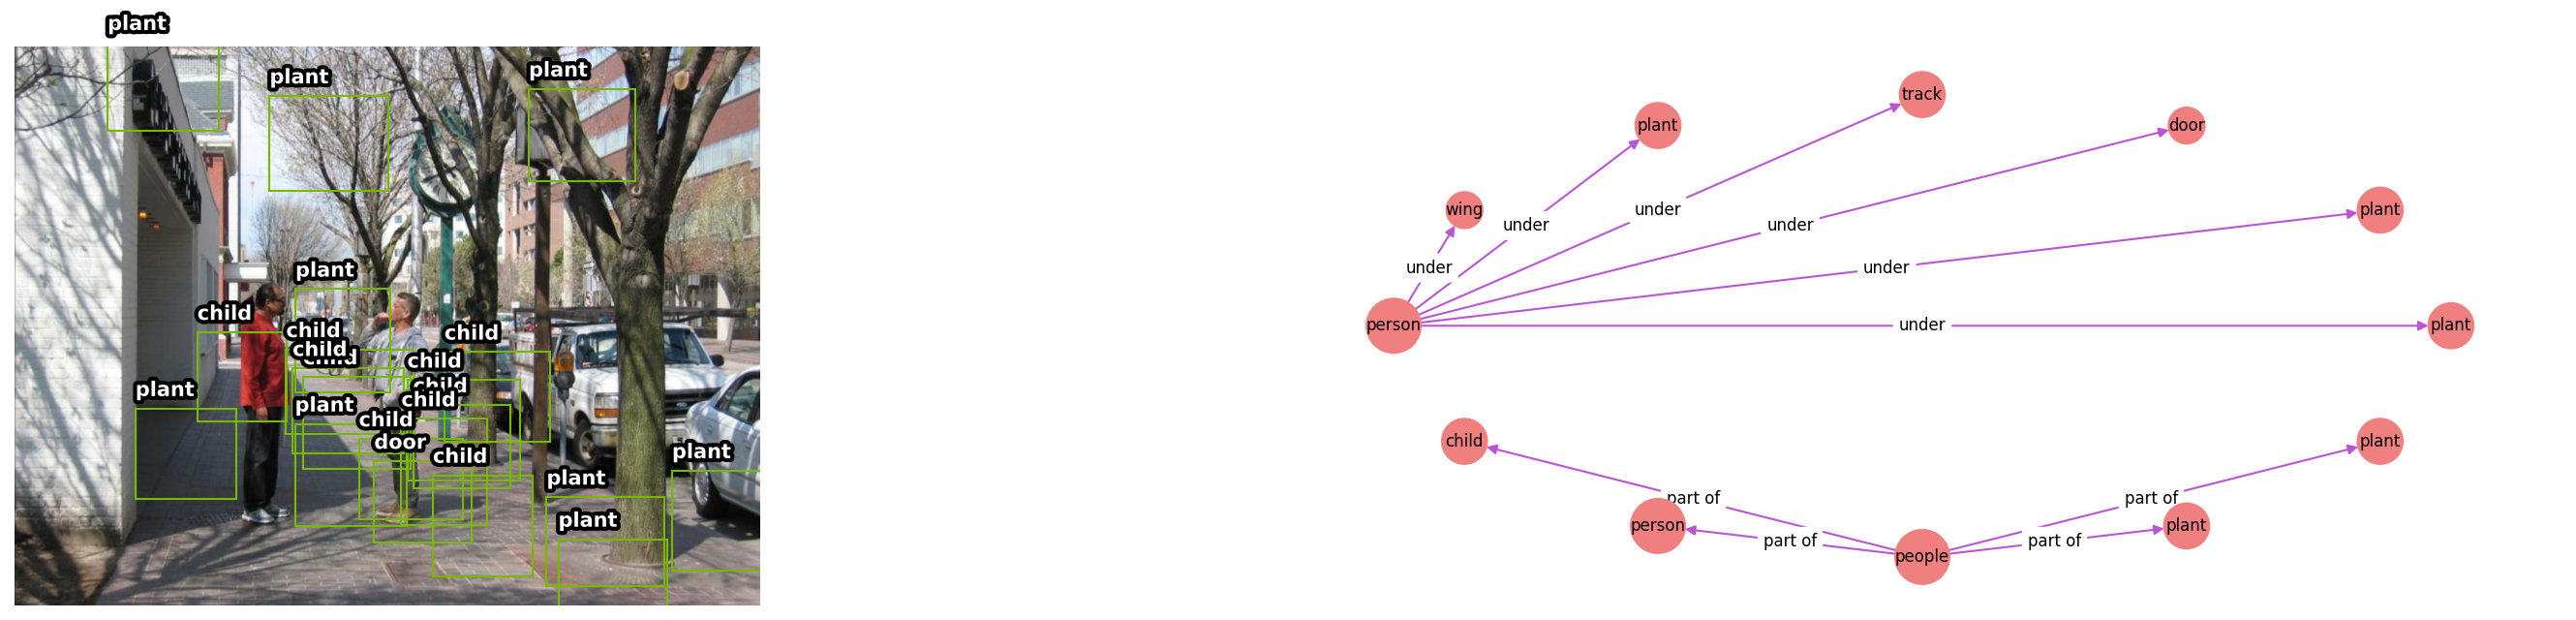

In [118]:
max_relations = 10
max_obj = 20
plot_val_rel_sample(images[0].permute(1,2,0).cpu().numpy(),  bbox2,  labels2,  edges2, obj_score, rel_score,max_obj, max_relations)